In [1]:
### TO DO notes 

# compare sham with SALPA to sham without SALPA 
# gather sham with SALPA, write band rectification code to get values, then low pass filter to get all data filtered to the end

# post process the data before the average, get raw runs, apply salpa, de band rectification, then low pass filter then look at avergae. 
# do the same with sham but skip salpa, do remove the artifacts????
# get all averages of sham with SALPA and overimpose to see over all response. 

# do the same with the sham without SALPA and compare for multiple electrodes 

%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
dir3 = dir1+'/spike_tools'
if not dir1 in sys.path: sys.path.append(dir1)
if not dir3 in sys.path: sys.path.append(dir3)

from spike_tools.utils.spikeutils import remove_artefacts, remove_artefacts_mod, remove_artefacts_feng, remove_artefacts_reverse

import numpy as np
import joblib
import scipy.io as sio
import pandas as pd

import xarray
import matplotlib.pyplot as plt
import seaborn as sns

import logging

from pathlib import Path

from sklearn.linear_model import LinearRegression
# from brainscore.metrics.regression import pearsonr
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import os


# from brainio_base.assemblies import NeuronRecordingAssembly
import brainscore

from utils.intanutils import read_amplifier
from utils.filter import bandpass_filter, notch_filter
from utils import find_nearest


from scipy import signal, interpolate
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.fft import fft, fftfreq


import configparser


config = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
config.read('../spike_tools/spike_config.ini')

/braintree/home/fakhoury/miniconda3/lib/python3.7/site-packages/brainscore/metrics/__init__.py:37: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


['../spike_tools/spike_config.ini']

# Prepare Data

In [3]:
config['Experiment Information']['name'] = 'stimulation-with-control'
date = '211001'


dataPath = "/braintree/data2/active/users/ssazaidi/projects/"+config['Experiment Information']['name']+"/monkeys/oleo/"
procDataPath = dataPath+'intanproc'
rawDataPath =  dataPath+'intanraw'

### Load MWORKS DATA ###

mworksDirproc = '/braintree/data2/active/users/ssazaidi/projects/'+config['Experiment Information']['name']+'/monkeys/oleo/mworksproc/'
mworksFilename = [i for i in os.listdir(mworksDirproc) if date in i][0]
data_info = pd.read_csv(os.path.join(mworksDirproc, mworksFilename))
samp_on_id = data_info.stim_id.values
samp_on_current = data_info.stim_current.values

In [4]:
### Define necessary paths ###

artefact_times_path = os.path.join(rawDataPath, date, 'artefact_time_'+date+'.pkl')
samp_filename = os.path.join(rawDataPath,date,'samp_time_'+date+'.pkl')
mworksproc_name = os.path.join(dataPath, 'mworksproc', [i for i in os.listdir(dataPath+'mworksproc') if date in i][0] )   

In [5]:
### Create Channel List ###
channel_letters = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
channel_numbers = np.arange(32)


all_channels = np.array(np.meshgrid( channel_numbers, channel_letters)) # mesh grid variable of all channel names
all_channels = np.core.defchararray.add(np.core.defchararray.add(all_channels[1],'-'),np.char.zfill(all_channels[0], 3))
all_channels = all_channels.flatten() 

n_channels = len(all_channels) # number of channels for recording


In [6]:
### Set variables ###
recording_channel = 'C-024'  # which channel to record from
samplingFrequency = 20000    # fs not to change
f_low = 300    # bp frequencies
f_high = 5000

num_pulses=10    # set not to change
pulse_width_usec=4000 # length of stimulation pulse, 40 micro seconds, x 10 x 10

channel_num = np.where(all_channels == recording_channel.lower())[0][0]
# print(channel_num)

# Load Data

In [7]:
if os.path.exists(samp_filename):
    samp_on = joblib.load(samp_filename)
else:
    filename = Path(os.path.join(directory_path, 'board-DIGITAL-IN-02.dat'))
    fid = open(filename, 'r')
    filesize = os.path.getsize(filename) # in bytes
    num_samples = filesize // 2 # uint16 = 2 bytes
    din02 = np.fromfile(fid, 'uint16', num_samples)
    fid.close()

    samp_on, = np.nonzero(din02[:-1] < din02[1:]) # Look for 0->1 transitions
    samp_on = samp_on + 1 # Previous line returns indexes of 0s seen before spikes, but we want indexes of first spikes
    joblib.dump(samp_on, samp_filename)


data_info = pd.read_csv(mworksproc_name)
samp_on_id = data_info.stim_id.values
samp_on_current = data_info.stim_current.values


artefact_times = joblib.load(artefact_times_path)
nan_sums = np.sum(np.isnan(artefact_times), axis=0)
good_ones = np.where(nan_sums < 96)[0]

artefact_times = np.nanmedian(artefact_times, axis=0).astype(int)
artefact_times = artefact_times[good_ones]


/braintree/home/fakhoury/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [8]:
# Get names of all directories with the specified 'date'.
with os.scandir(rawDataPath) as it:
    dirs = [entry.name for entry in it if (entry.is_dir() and entry.name.find(date) != -1 and entry.name != date)]
dirs.sort()

d = dirs[0]
# Get all raw neural data files
with os.scandir(os.path.join(rawDataPath, d)) as it:
    files = [entry.name for entry in it if (entry.is_file() and entry.name.find('amp') != -1)]
files.sort()  # The files are randomly loaded, so sort them
print(n_channels, len(files))
assert len(files) == n_channels  # Check if number of files matches number of channels


v = read_amplifier(os.path.join(rawDataPath, d, files[channel_num]))  # In microvolts - reading data
# v = notch_filter(v, f_sampling=samplingFrequency, f_notch=60, bandwidth=10)



192 192


# Sham Runs Analysis

In [10]:
len(samp_on_current), len(artefact_times), len(good_ones) # verify length of samples

(6500, 6500, 6500)

### Define variables and processing functions

In [9]:
fs = samplingFrequency
pre_ = 2000 #0.1*fs # setting plotting boundaries 
post_ = 4000 #0.2*fs

t= 1000* np.arange(-pre_, post_) /fs


## signal with removed artifacts
v1 = remove_artefacts_mod(v, artefact_times, samplingFrequency, f_low, f_high, art_time_usec=900, 
                     v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=False, samp_current=1);

## signal with removed artifacts and SALPA
v2 = remove_artefacts_mod(v, artefact_times, samplingFrequency, f_low, f_high, art_time_usec=900, 
                     v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=True, samp_current=1);




pulse_width is:  81
900
pulse_width is:  81
900


### Isolate Sham runs

In [10]:
## only for sham 
sham_index = np.where(samp_on_current==0)
sample_time = artefact_times
pre_ = int(0.01*fs) # setting plotting boundaries 
post_ = int(0.05*fs)
color_ = 'k'

# print(np.size(sham_index))
stim_current = 0 # target stim current
stim_ids = np.unique(samp_on_id)
stim_id = stim_ids[10]

sham_idx = np.where(np.logical_and(data_info['stim_id'] == stim_id , data_info['stim_current'] == stim_current))[0]
art_num = sham_idx[2] # 1-122
print(art_num)


93


### Plot Sham with SALPA

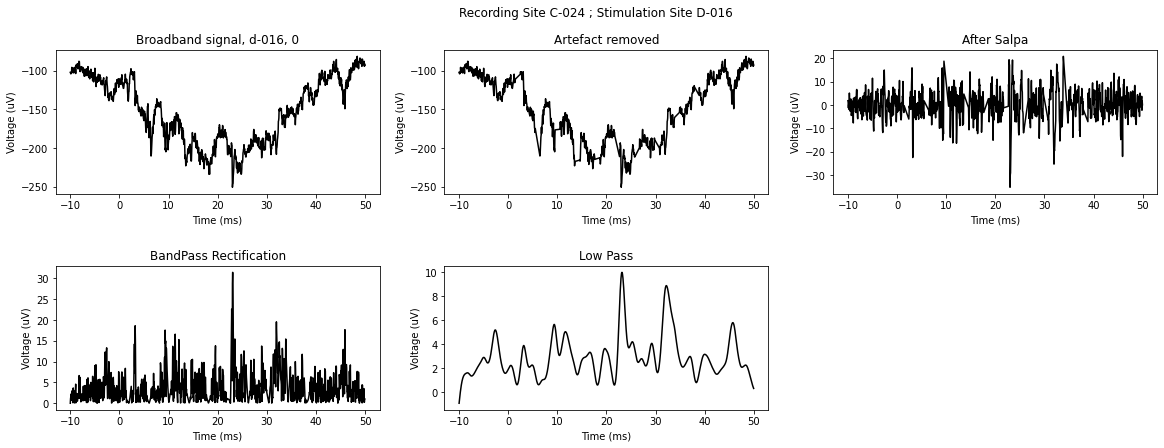

In [11]:
### figure dimensions set up 
color_ = 'k' # set plot colors
width=0.3
height= 0.1
pad_ratio_x = 0.2
pad_ratio_y = 0.5
fig = plt.figure(figsize=[15,20]) # set figure dimensions



### Raw (broadband) signal 
row = 0
column= 0
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height
ax = fig.add_axes([left,bottom, width,height])

broadband_signal = v[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal, 'k')
plt.title('Broadband signal, '+str(samp_on_id[art_num])+', '+ str(samp_on_current[art_num]))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')


### Artefact removed 
row = 0
column= 1
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height
ax = fig.add_axes([left,bottom, width,height])

broadband_signal_artefact_removed = v1[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_artefact_removed, color_)
plt.title('Artefact removed')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')


### Salpa
row = 0
column= 2
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height

ax = fig.add_axes([left,bottom, width,height])
broadband_signal_salpa = v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_salpa, color_)
plt.title('After Salpa')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')



### Band passed and rectified
row = 1
column= 0
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height
axes1 = fig.add_axes([left,bottom, width,height])

f_low = 1000
f_high = 5000
broadband_signal_bandpass_rectification = np.abs(bandpass_filter(v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_], samplingFrequency, f_low, f_high))
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_bandpass_rectification, color_)
plt.title('BandPass Rectification')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')



### low pass filtered (as box filter for spikes) 
row = 1
column= 1
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height

ax = fig.add_axes([left,bottom, width,height])
f_low = 0.1
f_high = 200
broadband_signal_low_pass = bandpass_filter(broadband_signal_bandpass_rectification, samplingFrequency, f_low, f_high)
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_low_pass, color_)
plt.title('Low Pass')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')


plt.suptitle(' '.join(['Recording Site', all_channels[channel_num].capitalize(), ';','Stimulation Site', samp_on_id[art_num].capitalize()]))

plt.savefig('_'.join(['Figures/Combined_Plots','rec_site', all_channels[channel_num],'stim_site', samp_on_id[art_num]]), bbox_inches='tight')
plt.show()
plt.close()

### Plot sham without SALPA 

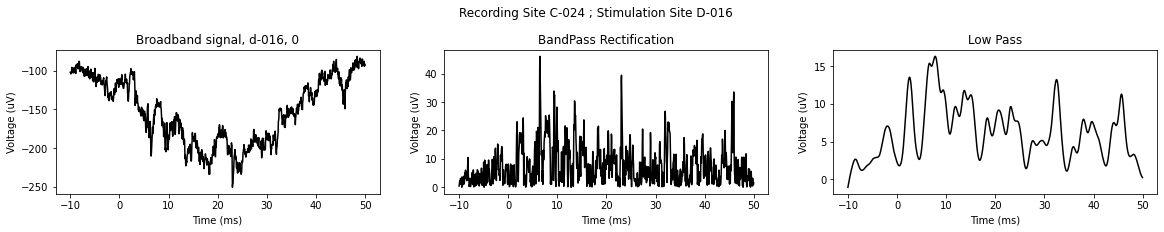

In [16]:
### figure dimensions set up 
color_ = 'k' # set plot colors
width=0.3
height= 0.1
pad_ratio_x = 0.2
pad_ratio_y = 0.5
fig = plt.figure(figsize=[15,20]) # set figure dimensions

### Raw (broadband) signal 
row = 0
column= 0
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height
ax = fig.add_axes([left,bottom, width,height])

broadband_signal = v[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal, 'k')
plt.title('Broadband signal, '+str(samp_on_id[art_num])+', '+ str(samp_on_current[art_num]))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')


### Band passed and rectified
row = 0
column= 1
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height
axes1 = fig.add_axes([left,bottom, width,height])

f_low = 300
f_high = 5000
broadband_signal_bandpass_rectification = np.abs(bandpass_filter(v[artefact_times[art_num]-pre_:artefact_times[art_num]+post_], samplingFrequency, f_low, f_high))
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_bandpass_rectification, color_)
plt.title('BandPass Rectification')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')


### low pass filtered (as box filter for spikes) 
row = 0
column= 2
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height

ax = fig.add_axes([left,bottom, width,height])
f_low = 0.1
f_high = 200
broadband_signal_low_pass = bandpass_filter(broadband_signal_bandpass_rectification, samplingFrequency, f_low, f_high)
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_low_pass, color_)
plt.title('Low Pass')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')


plt.suptitle(' '.join(['Recording Site', all_channels[channel_num].capitalize(), ';','Stimulation Site', samp_on_id[art_num].capitalize()]))
plt.savefig('_'.join(['Figures/Combined_Plots','rec_site', all_channels[channel_num],'stim_site', samp_on_id[art_num]]), bbox_inches='tight')
plt.show()
plt.close()

# Get average for sham trials

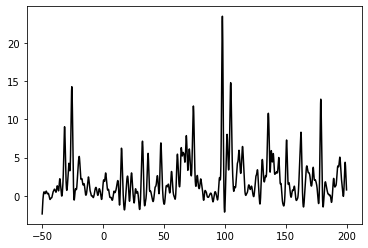

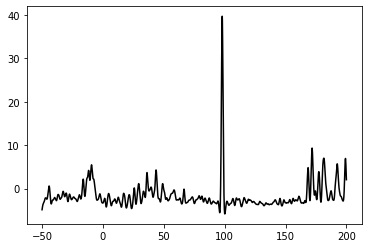

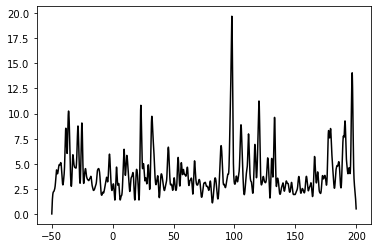

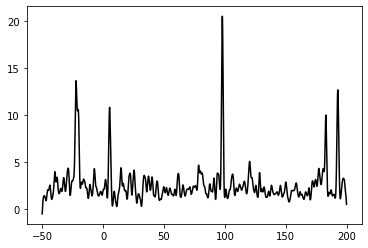

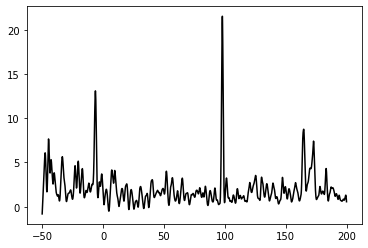

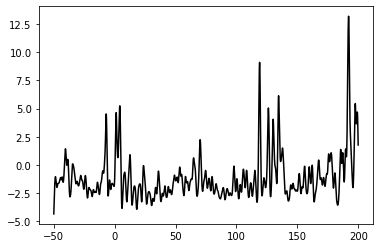

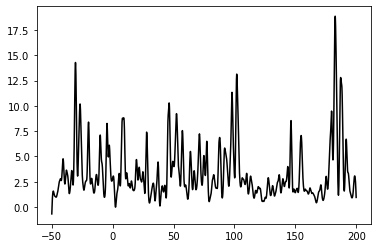

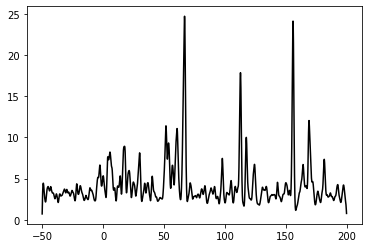

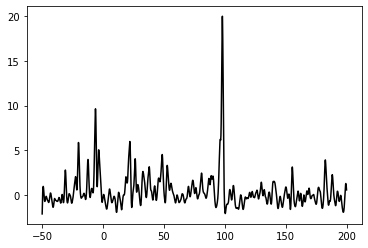

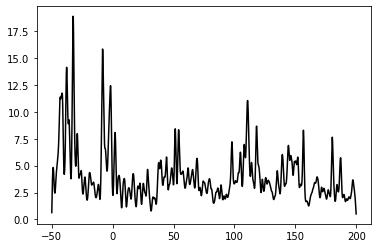

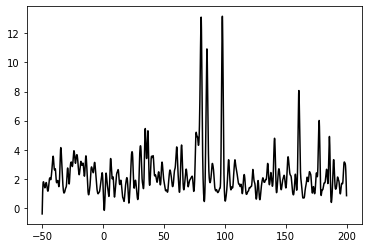

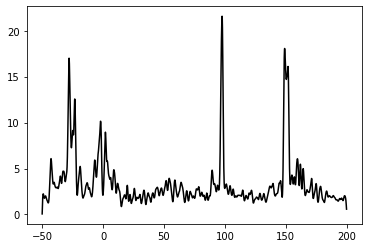

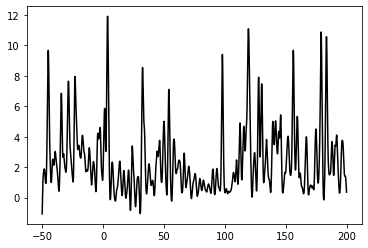

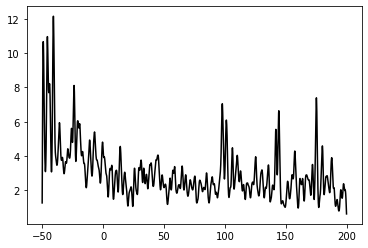

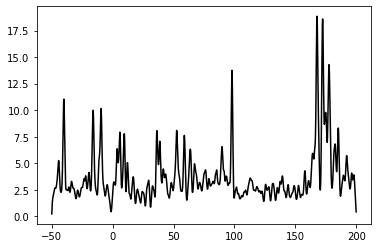

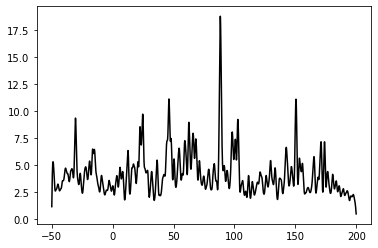

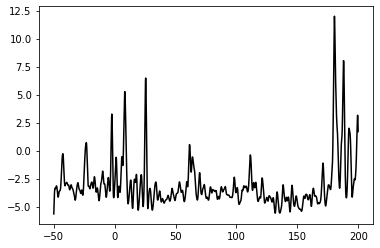

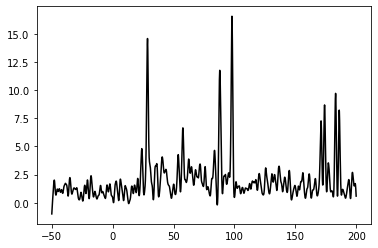

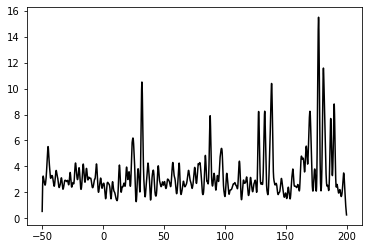

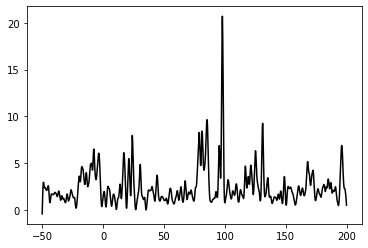

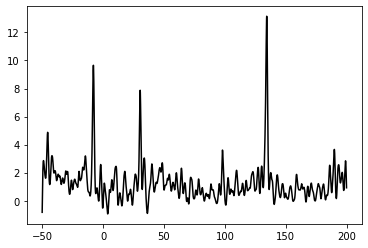

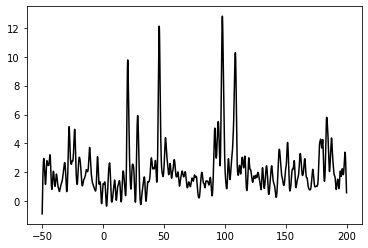

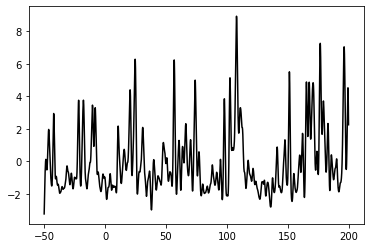

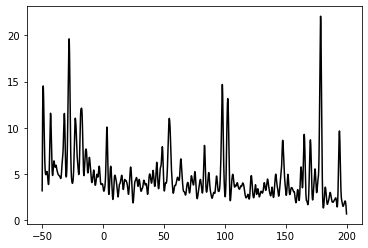

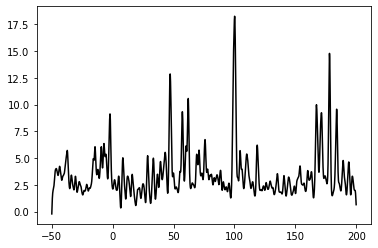

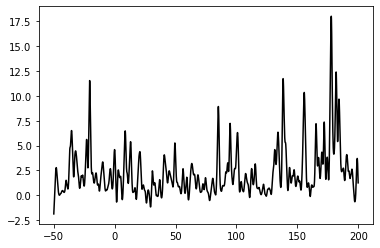

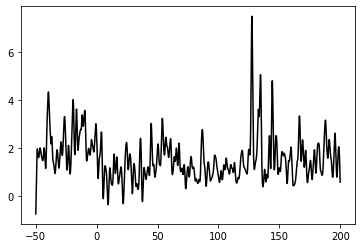

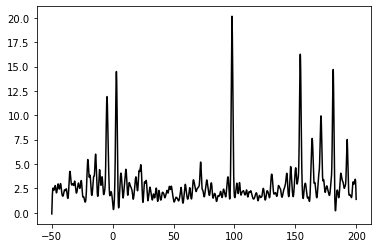

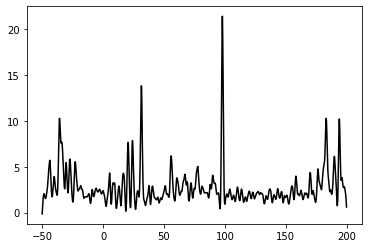

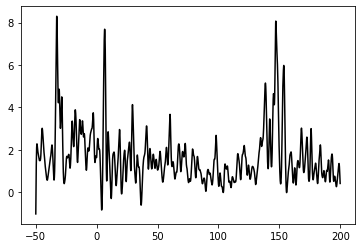

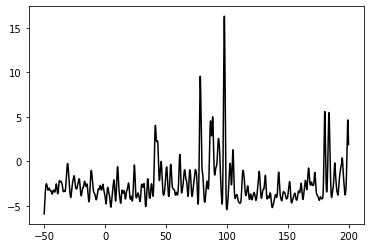

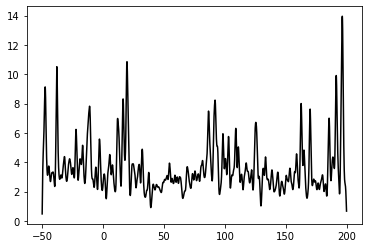

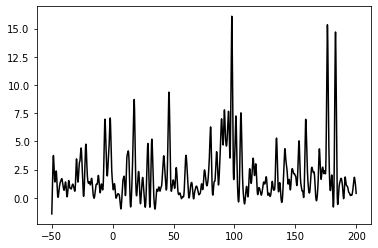

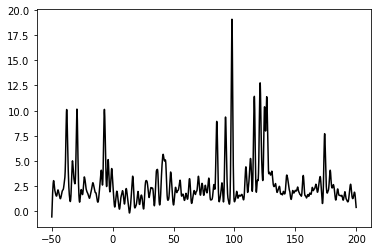

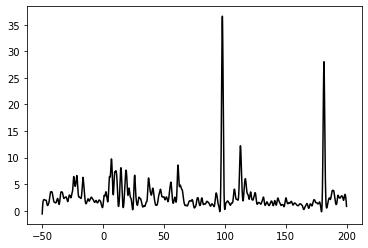

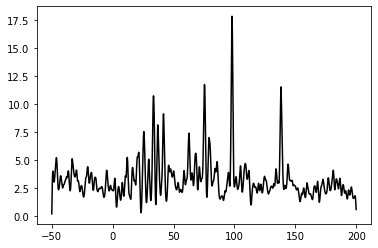

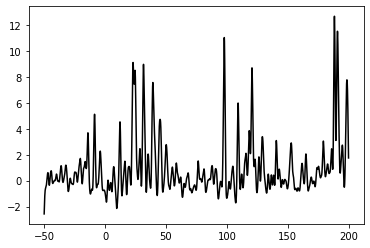

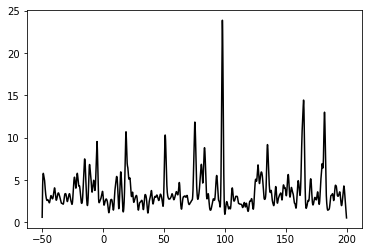

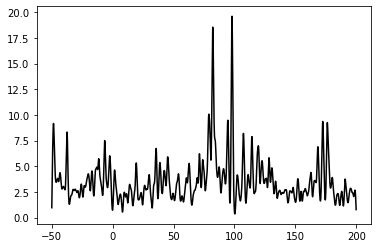

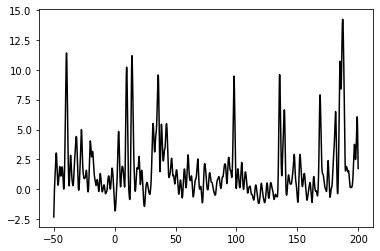

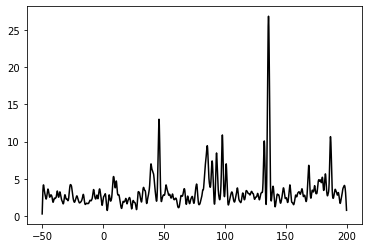

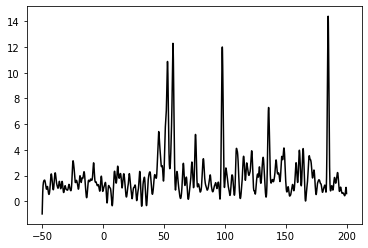

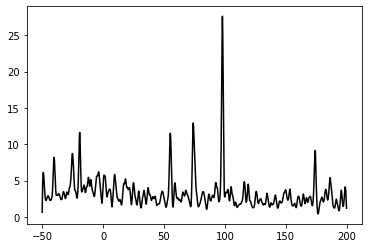

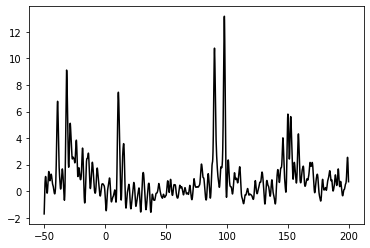

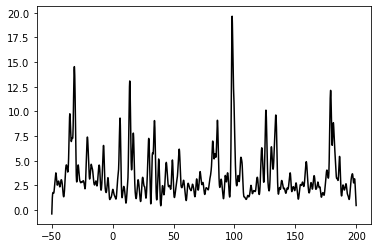

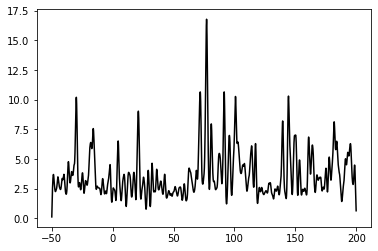

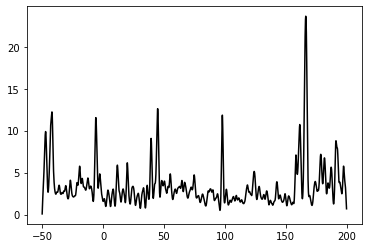

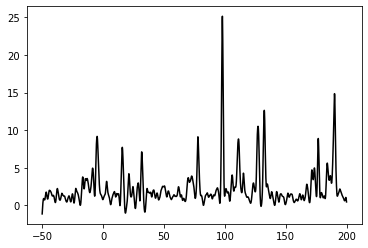

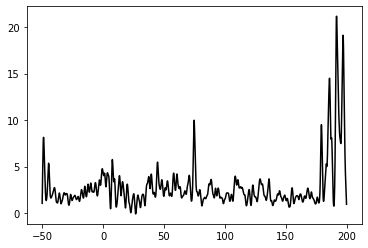

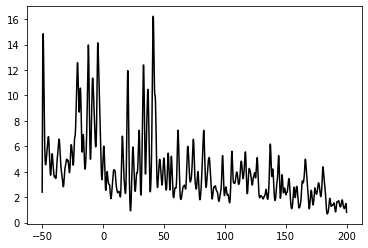

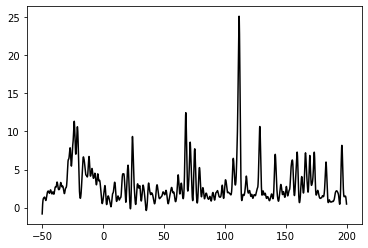

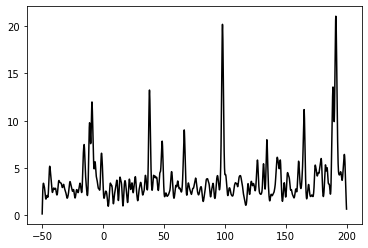

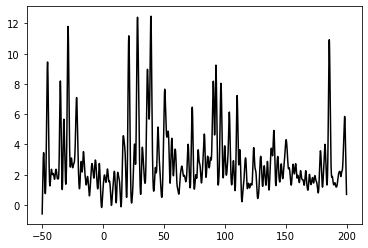

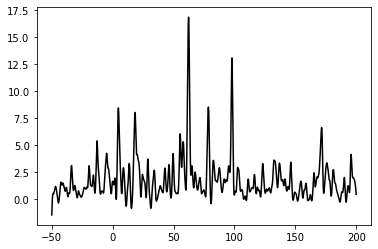

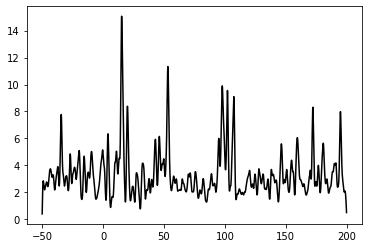

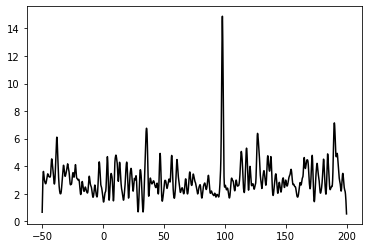

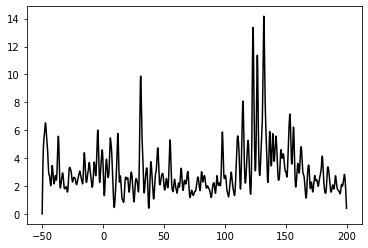

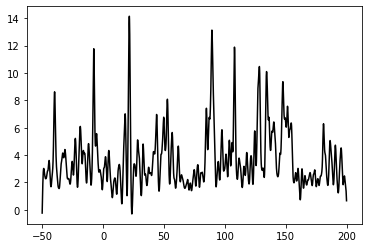

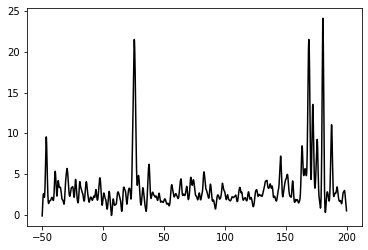

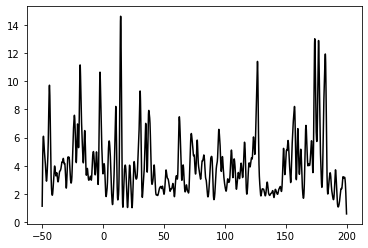

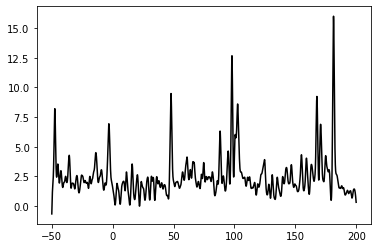

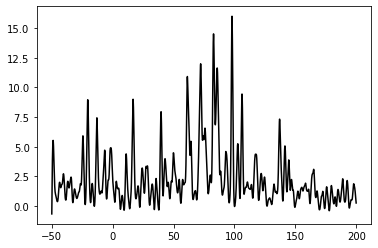

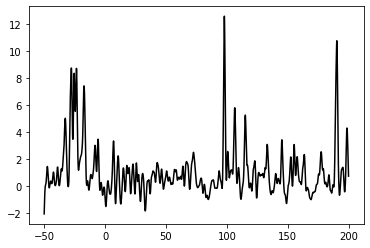

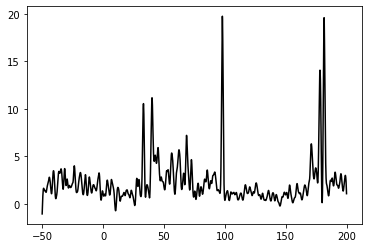

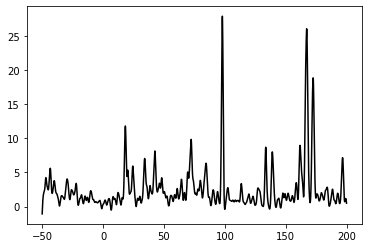

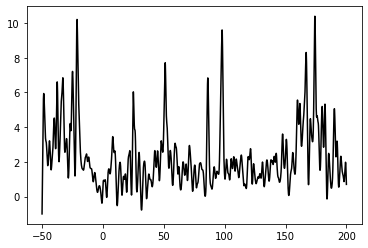

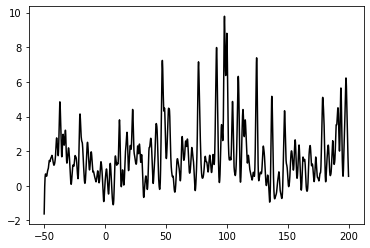

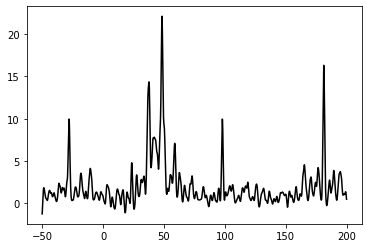

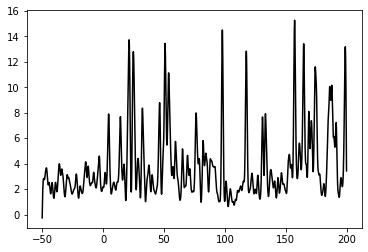

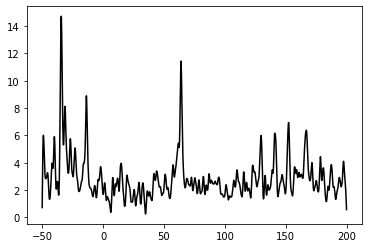

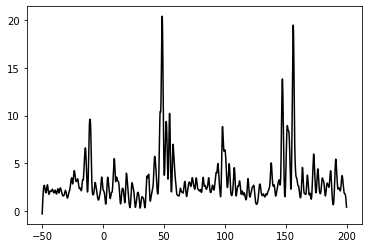

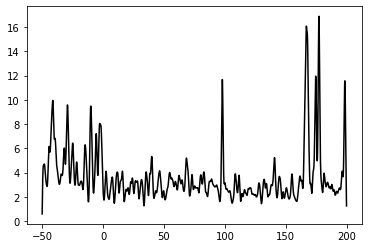

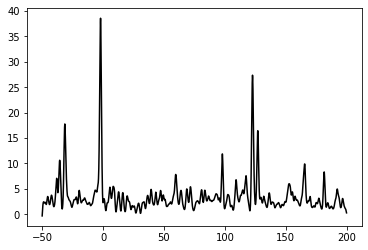

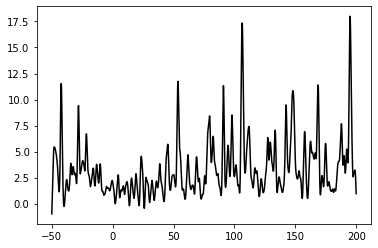

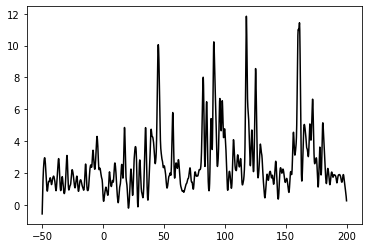

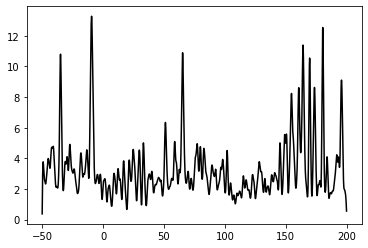

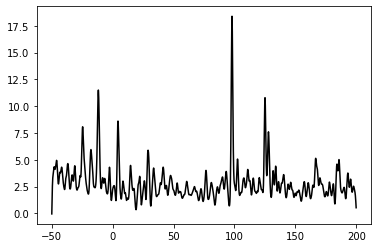

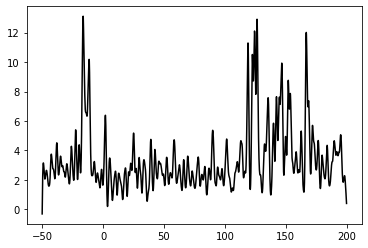

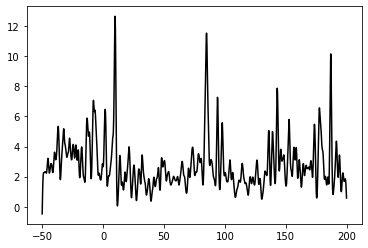

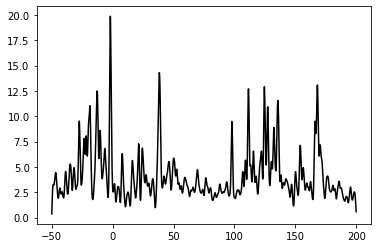

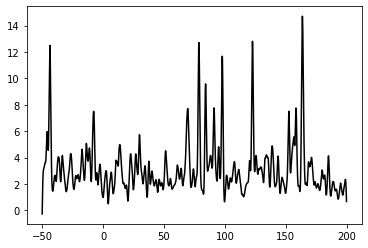

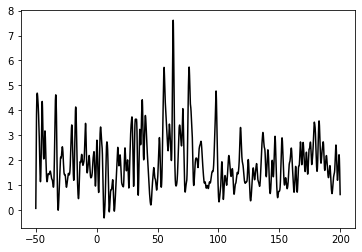

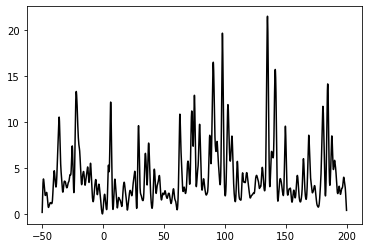

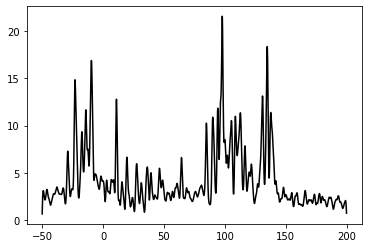

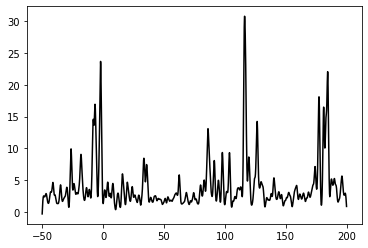

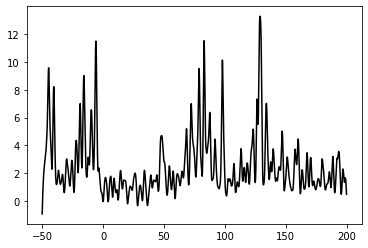

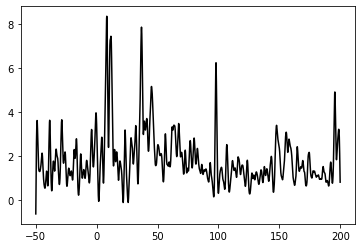

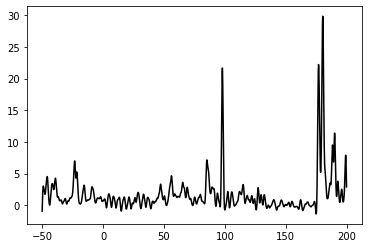

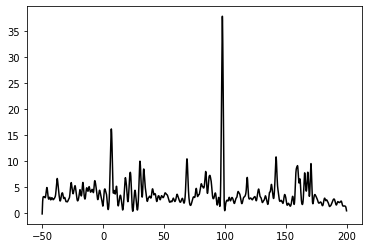

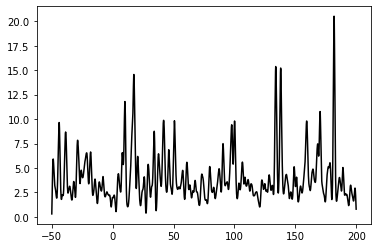

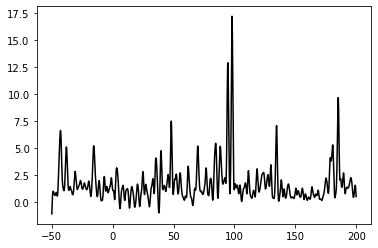

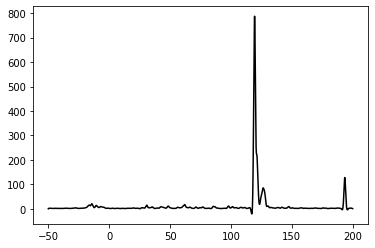

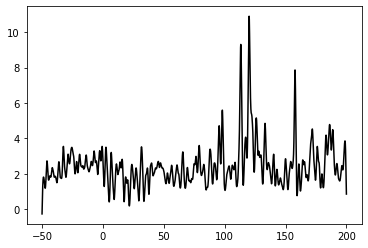

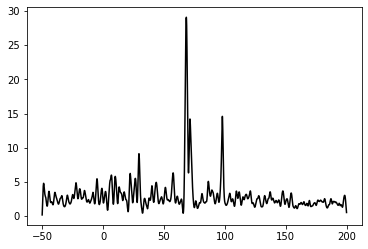

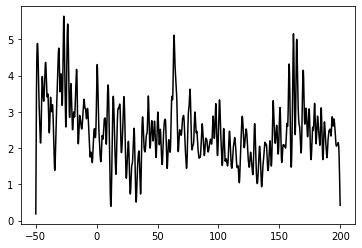

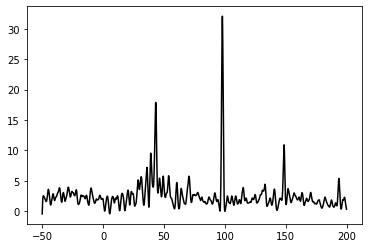

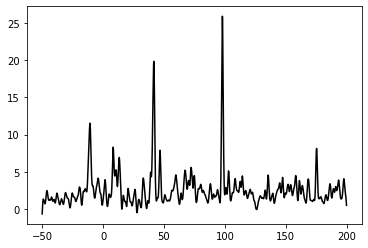

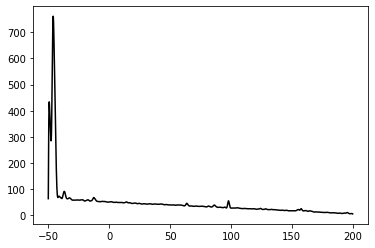

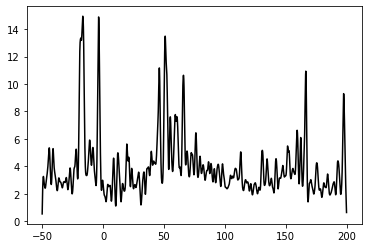

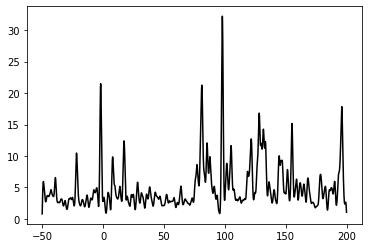

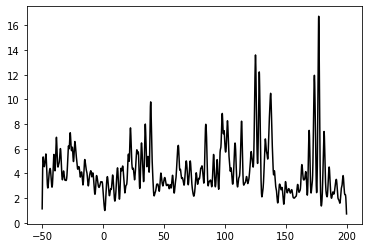

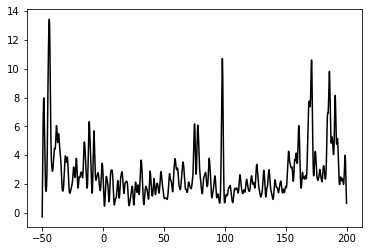

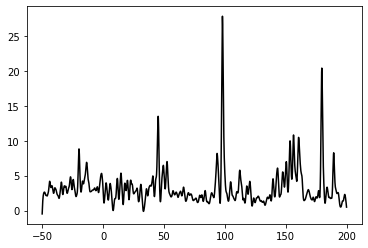

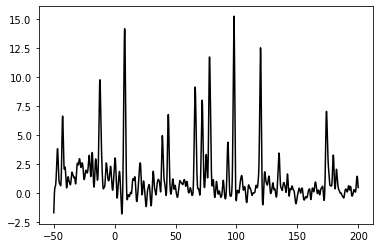

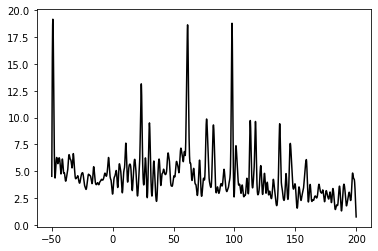

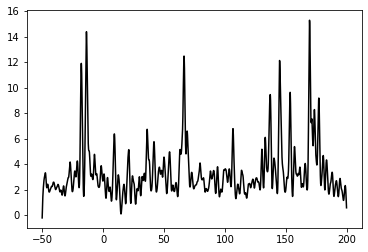

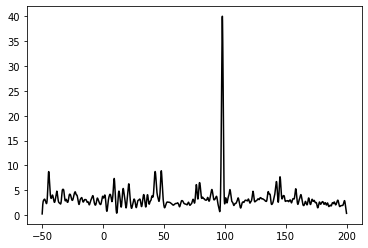

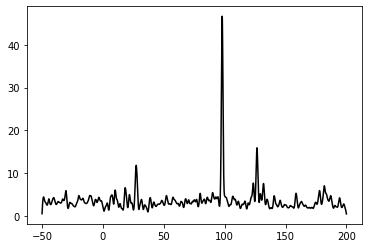

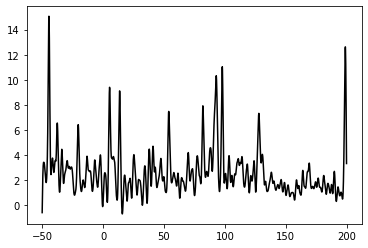

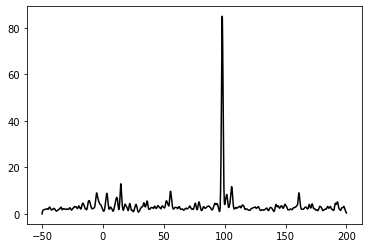

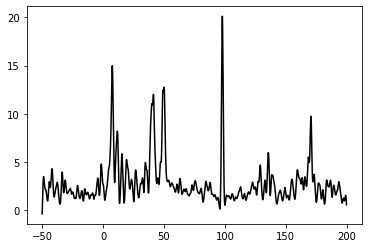

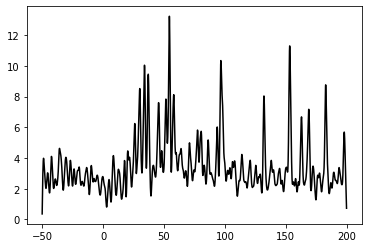

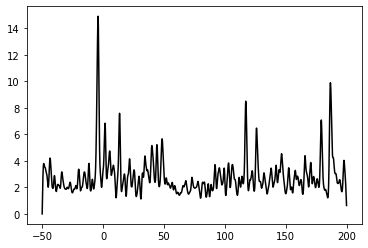

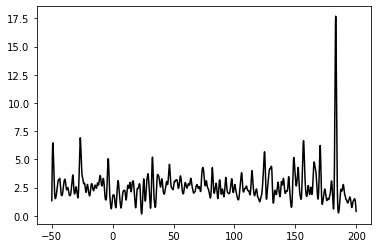

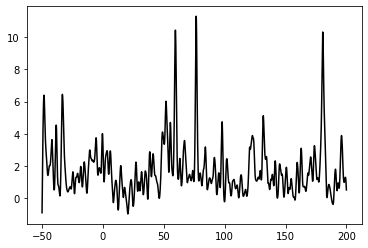

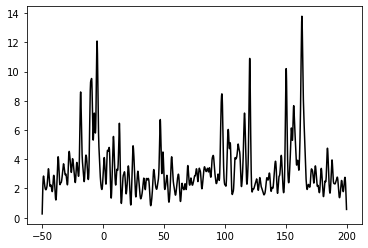

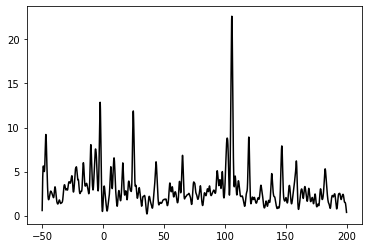

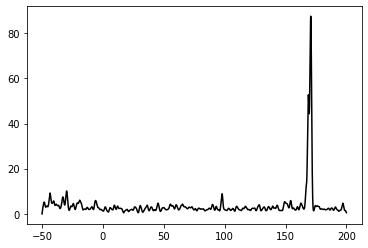

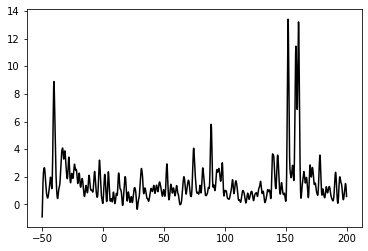

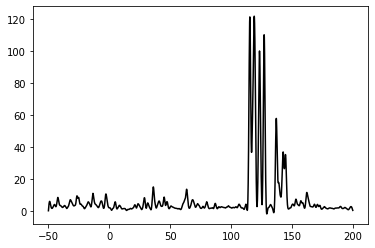

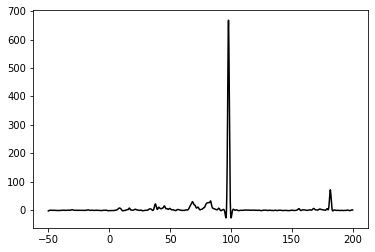

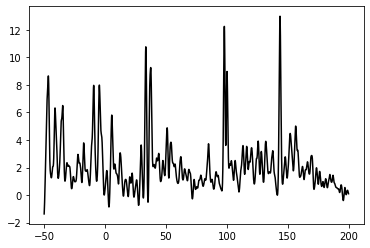

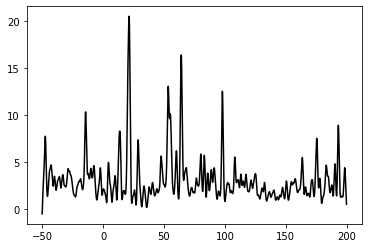

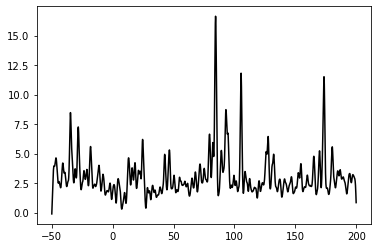

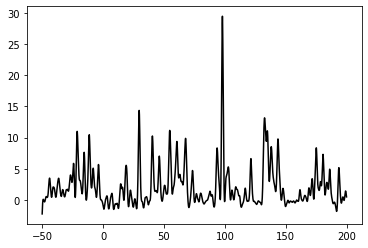

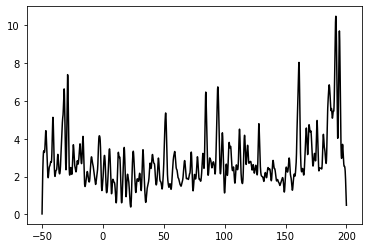

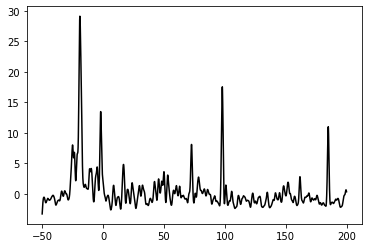

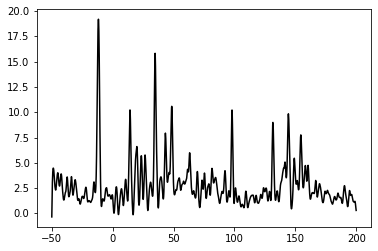

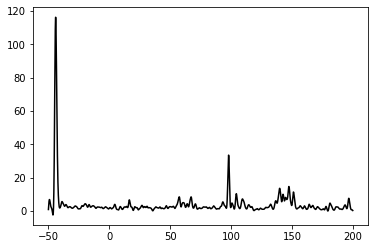

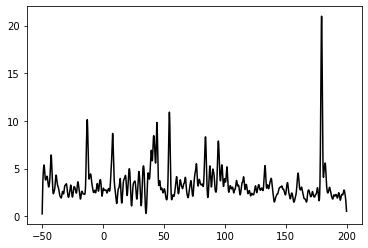

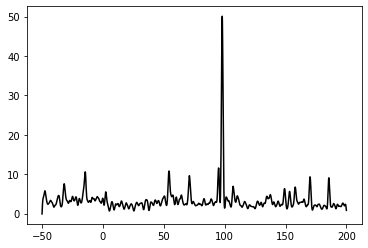

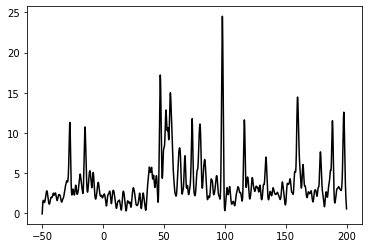

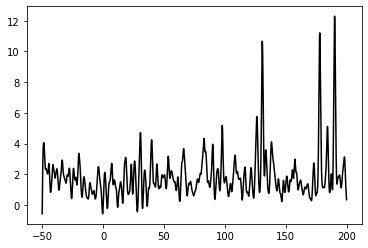

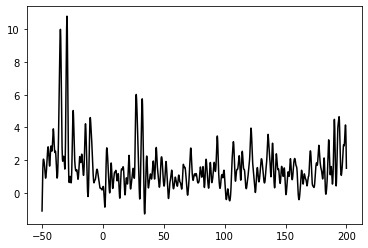

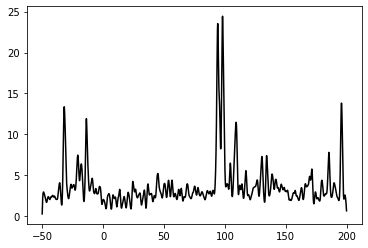

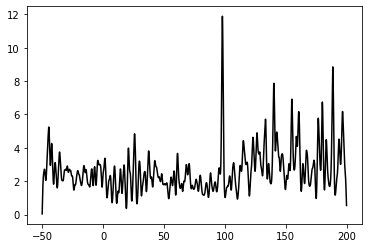

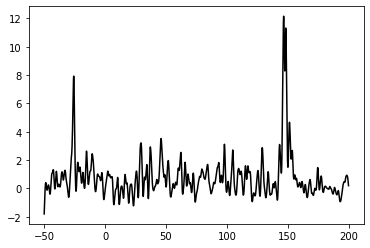

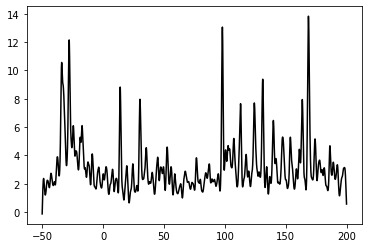

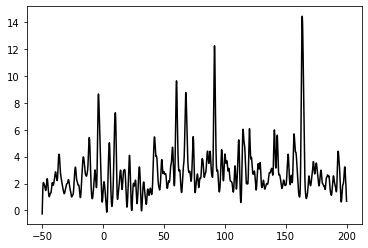

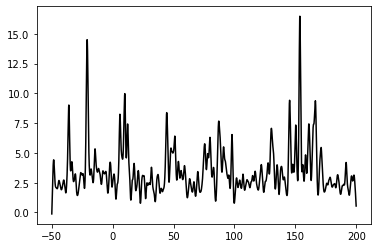

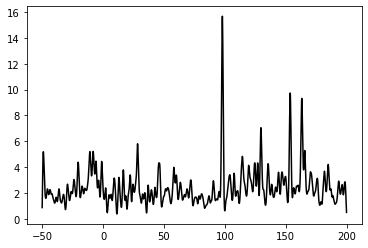

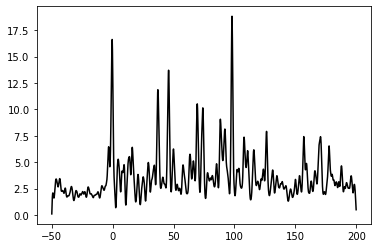

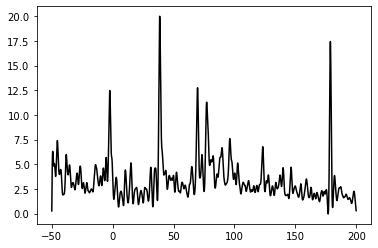

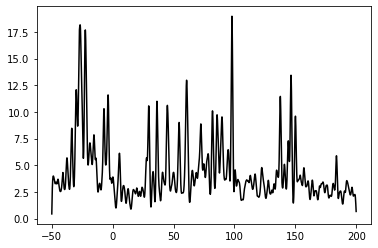

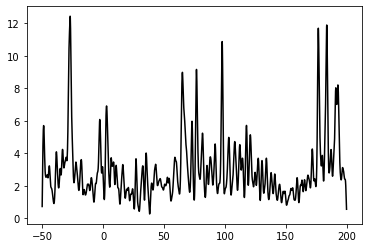

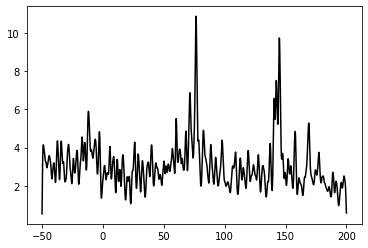

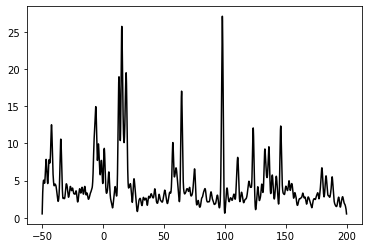

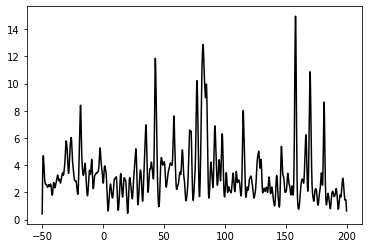

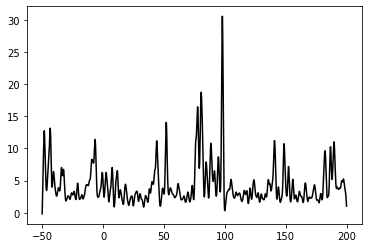

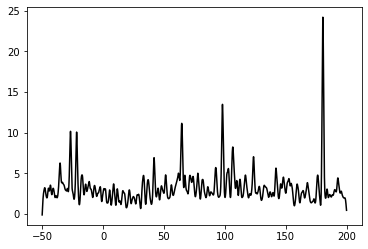

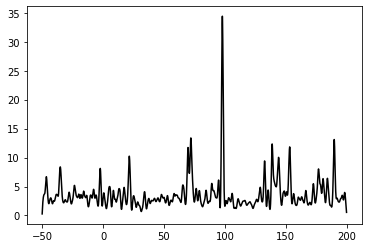

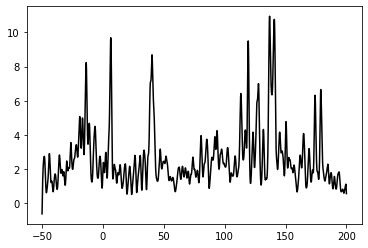

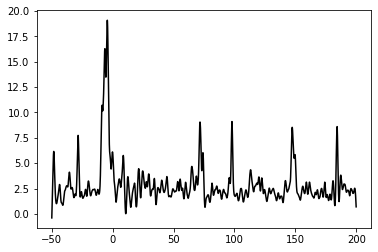

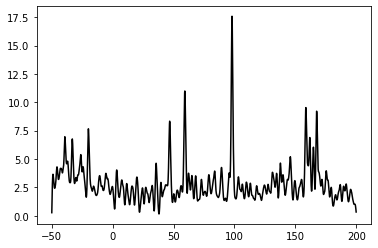

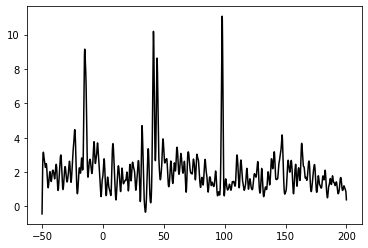

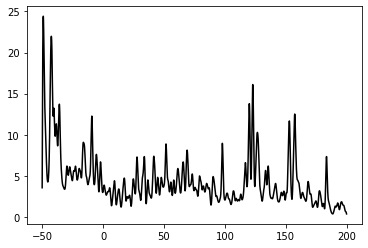

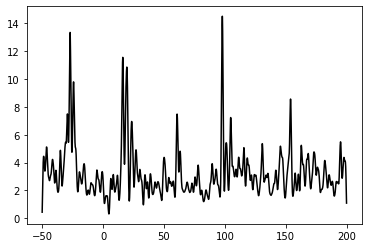

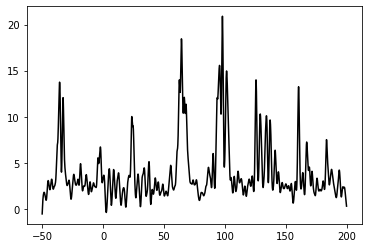

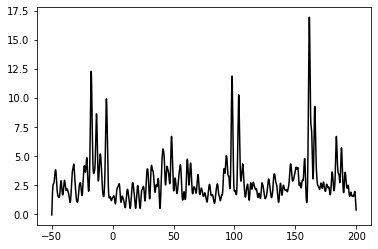

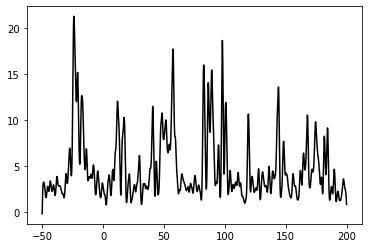

In [12]:
## Set averaging windows (art_num is already set previously from sham indeces)
pre_ = int(0.05*fs) # setting plotting boundaries 
post_ = int(0.2*fs)
t= 1000* np.arange(-pre_, post_) /samplingFrequency


f_low_1 = 1000
f_high_1 = 5000

f_low_2 = 0.1
f_high_2 = 200

average_ = np.zeros((post_+pre_))
 
# print(sham_idx)
for art_num in sham_idx:
    salpa_signal = v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
    bp_rect_signal = np.abs(bandpass_filter(salpa_signal, samplingFrequency, f_low_1, f_high_1))
    low_pass_signal = bandpass_filter(bp_rect_signal, samplingFrequency, f_low_2, f_high_2)
    average_ += low_pass_signal
    f = plt.figure()
    plt.plot(t,low_pass_signal,color_)
    plt.show()
    plt.close()
    
    
average_ /= np.size(sham_idx)
    


Text(0, 0.5, 'Voltage (uV)')

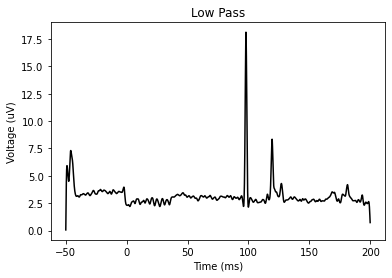

In [13]:
## plot average signal for one electrode over sham trials

t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, average_, color_)
plt.title('Low Pass')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')

In [ ]:
# v_band_passed1 = bandpass_filter(v1, samplingFrequency, f_low, f_high)
# v_band_passed1 = v_band_passed1 - np.nanmean(v_band_passed1)

# v_band_passed2 = bandpass_filter(v2, samplingFrequency, f_low, f_high)
# v_band_passed2 = v_band_passed2 - np.nanmean(v_band_passed2)